In [1]:
import powerplantmatching as pm

INFO:numexpr.utils:Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
ERROR:fiona._env:/trinity/home/thomgeo/.conda/envs/pypsa-training/lib/python3.10/site-packages/PIL/../../../libtiff.so.6: version `LIBTIFF_4.6.1' not found (required by /trinity/home/thomgeo/micromamba/envs/lmp-v13/lib/gdalplugins/../libgdal.so.35)
ERROR:fiona._env:/trinity/home/thomgeo/.conda/envs/pypsa-training/lib/python3.10/site-packages/PIL/../../../libtiff.so.6: version `LIBTIFF_4.6.1' not found (required by /trinity/home/thomgeo/micromamba/envs/lmp-v13/lib/gdalplugins/../libgdal.so.35)
ERROR:fiona._env:/trinity/home/thomgeo/.conda/envs/pypsa-training/lib/python3.10/site-packages/PIL/../../../libtiff.so.6: version `LIBTIFF_4.6.1' not found (required by /trinity/home/thomgeo/micromamba/envs/lmp-v13/lib/gdalplugins/../libgdal.so.35)
ERROR:fiona._env:/trinity/home/thomgeo/.conda/envs/pypsa-training/lib/python3.10/site

In [2]:
import linopy
import numpy as np

In [3]:
import pycountry

In [4]:
import geopandas as gpd

In [5]:
power_plants = pm.powerplants()

In [6]:
res = ['Wind', 'Solar', "Hydro"]

In [7]:
power_plants = power_plants.query("(Fueltype not in @res)")

In [8]:
power_plants = power_plants[~(power_plants.DateOut < 2005)]

In [9]:
bidding_zones = gpd.read_file("resources/bidding_zones.geojson")

ERROR:fiona._env:/trinity/home/thomgeo/.conda/envs/pypsa-training/lib/python3.10/site-packages/PIL/../../../libtiff.so.6: version `LIBTIFF_4.6.1' not found (required by /trinity/home/thomgeo/micromamba/envs/lmp-v13/lib/gdalplugins/../libgdal.so.35)
ERROR:fiona._env:/trinity/home/thomgeo/.conda/envs/pypsa-training/lib/python3.10/site-packages/PIL/../../../libtiff.so.6: version `LIBTIFF_4.6.1' not found (required by /trinity/home/thomgeo/micromamba/envs/lmp-v13/lib/gdalplugins/../libgdal.so.35)
ERROR:fiona._env:/trinity/home/thomgeo/.conda/envs/pypsa-training/lib/python3.10/site-packages/PIL/../../../libtiff.so.6: version `LIBTIFF_4.6.1' not found (required by /trinity/home/thomgeo/micromamba/envs/lmp-v13/lib/gdalplugins/../libgdal.so.35)
ERROR:fiona._env:/trinity/home/thomgeo/.conda/envs/pypsa-training/lib/python3.10/site-packages/PIL/../../../libtiff.so.6: version `LIBTIFF_4.6.1' not found (required by /trinity/home/thomgeo/micromamba/envs/lmp-v13/lib/gdalplugins/../libgdal.so.35)
ERRO

In [10]:
power_plant_locations = gpd.GeoDataFrame(index=power_plants.index, geometry=gpd.points_from_xy(power_plants.lon, power_plants.lat), crs="EPSG:4326")
power_plant_locations = power_plant_locations.to_crs("EPSG:3035")

bidding_zones = bidding_zones.to_crs("EPSG:3035")

In [11]:
plant_to_zone = gpd.sjoin_nearest(
    power_plant_locations,
    bidding_zones,
    how="left"
)

In [12]:
plant_to_zone = plant_to_zone.groupby(plant_to_zone.index).last()

In [13]:
power_plants["zone"] = power_plants.index.map(plant_to_zone.zone)

<AxesSubplot:>

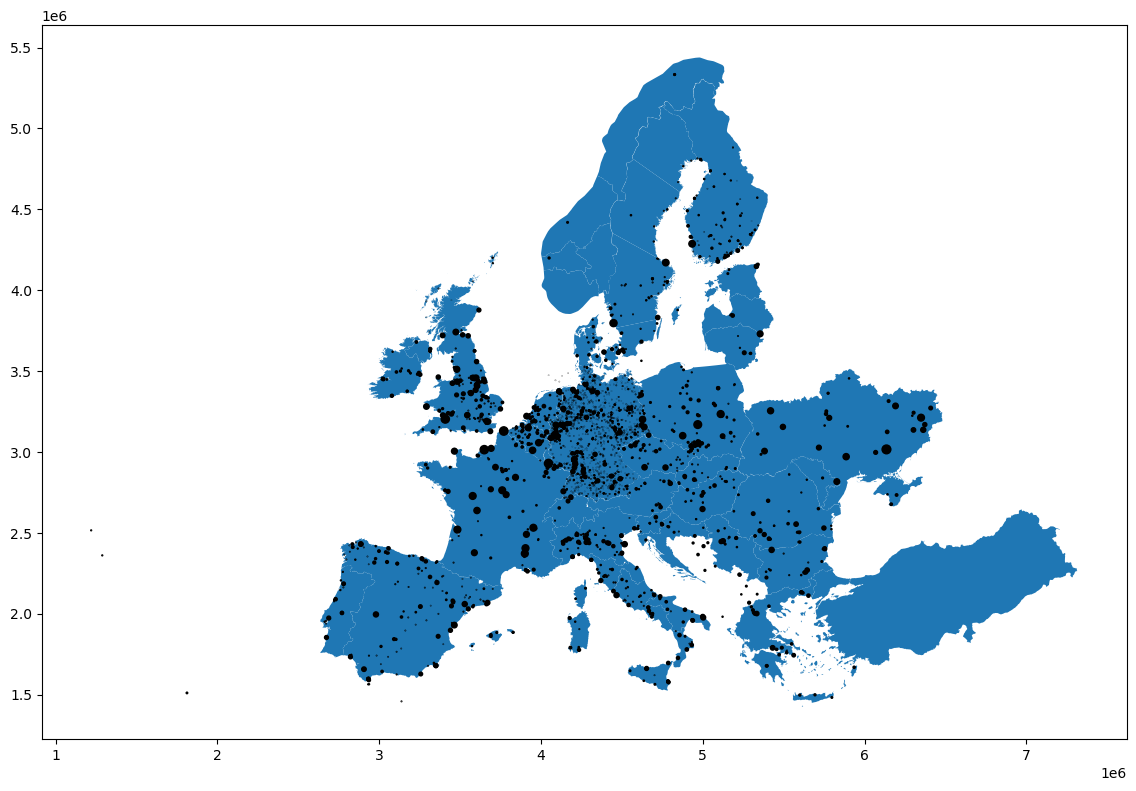

In [16]:
ax = bidding_zones.plot(figsize=(14,14))
power_plant_locations.plot(markersize=power_plants.Capacity.div(150), color="black", ax=ax)